In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# %matplotlib inline
plt.style.use('ggplot')
from IPython.display import display

# EDA
定位到目录

In [3]:
%pwd
#%cd Kaggle/Titanic/

'D:\\Project-Workspace\\Python-Projects\\DataAnalysis\\Kaggle\\Titanic-#1'

In [4]:
train = pd.read_csv('train.csv')
# 将 PassengerId 设置为index，它对于预测没有帮助
train.set_index('PassengerId', inplace=True)
display(train.head())
display(train.info())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


None

特征说明：
+ Pclass：Ticket Class, 取值 1 = 1st, 2 = 2nd, 3 = 3rd
+ Name: 姓名
+ Sex: 性别
+ Age: 年龄
+ SibSp: 船上有兄弟(Silbings)或配偶(Spouse)同行的人数    
兄弟和配偶关系的范围：brother, sister, stepbrother, stepsister, husband, wife
+ Parch: 船上有父母(Parents)或者子女(Children)同行的人数   
关系范围：nanny, mother, father, daughter, son, stepdaughter, stepson
+ Ticket: 船票号码
+ Fare: 船票费用
+ Cabin: 船舱编号
+ Embarked: 登船的码头，C = Cherbourg, Q = Queenstown, S = Southampton

预测变量：Survived: 0=No, 1=Yes

二分类问题，根据直觉，先检查下各个特征在预测变量上的分布。  
1. 这里不考虑Name，因为直觉上它和是否幸存没有关系。  
1. 对于船票编号Ticket，也不考虑。
1. 对于船舱编号Cabin，它的缺失值个数太多，也暂时不考虑。

In [9]:
# 为了方便绘图，需要对一些离散特征的类型做一下转换
# train = train.astype({'Sibsp': str, ''})
# train.info()

+ 使用seaborn做EDA

<AxesSubplot:xlabel='Age', ylabel='Survived'>

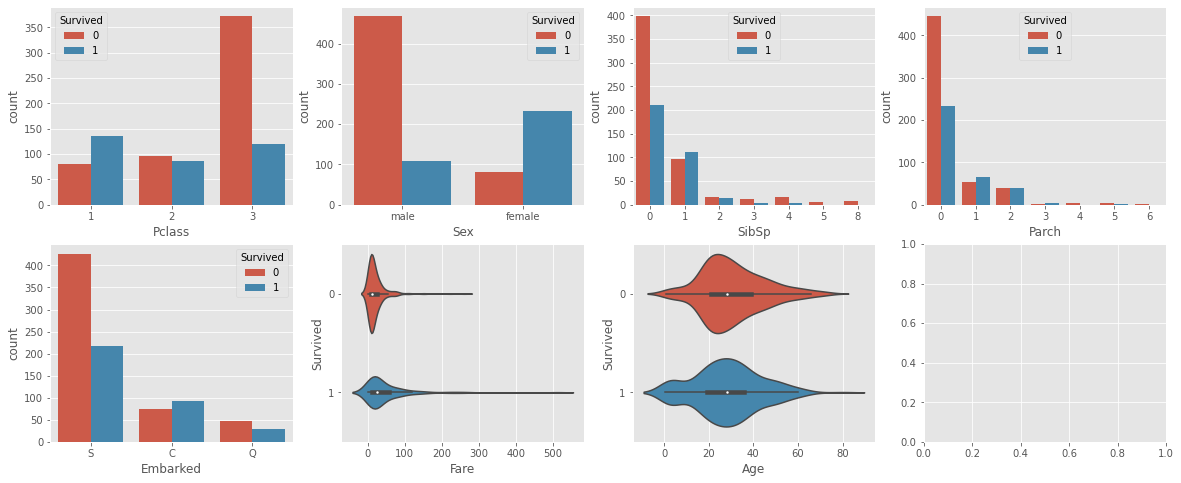

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
sns.countplot(data=train, x='Pclass', hue='Survived', ax=axes[0,0])
sns.countplot(data=train, x='Sex', hue='Survived', ax=axes[0,1])
sns.countplot(data=train, x='SibSp', hue='Survived', ax=axes[0,2])
sns.countplot(data=train, x='Parch', hue='Survived', ax=axes[0,3])
sns.countplot(data=train, x='Embarked', hue='Survived', ax=axes[1,0])
sns.violinplot(data=train, y='Survived', x='Fare', orient='h', ax=axes[1,1])
sns.violinplot(data=train, y='Survived', x='Age', orient='h', ax=axes[1,2])

+ 使用plotly做EDA

可以看出，使用plotly的话，需要自己做不少数据处理的工作，没有seaborn方便。

In [53]:
pclass_bar = train.groupby(['Pclass', 'Survived'], as_index=False).size()
pclass_bar['Survived'] = pclass_bar['Survived'].astype(str)
subfig_1 = px.bar(data_frame=pclass_bar, x='Pclass', y='size', color='Survived', barmode='group')
# subfig_1.show()

In [7]:
sex_bar = train.groupby(['Sex', 'Survived'], as_index=False).size()
sex_bar['Survived'] = sex_bar['Survived'].astype(str)
subfig_2 = px.bar(data_frame=sex_bar, x='Sex', y='size', color='Survived', barmode='group')
# subfig_2.show()

In [8]:
sibsp_bar = train.groupby(['SibSp', 'Survived'], as_index=False).size()
sibsp_bar['Survived'] = sibsp_bar['Survived'].astype(str)
subfig_3 = px.bar(data_frame=sibsp_bar, x='SibSp', y='size', color='Survived', barmode='group')
# subfig_3.show()

In [9]:
parch_bar = train.groupby(['Parch', 'Survived'], as_index=False).size()
parch_bar['Survived'] = parch_bar['Survived'].astype(str)
subfig_4 = px.bar(data_frame=parch_bar, x='Parch', y='size', color='Survived', barmode='group')
# subfig_4.show()

In [10]:
embarked_bar = train.groupby(['Embarked', 'Survived'], as_index=False).size()
embarked_bar['Survived'] = embarked_bar['Survived'].astype(str)
subfig_5 = px.bar(data_frame=embarked_bar, x='Embarked', y='size', color='Survived', barmode='group')
# subfig_5.show()

In [11]:
df = train.astype({'Survived': str})
subfig_6 = px.violin(data_frame=df, x='Fare', color='Survived')
# subfig_6.show()
subfig_7 = px.violin(data_frame=df, x='Age', color='Survived')
# subfig_7.show()

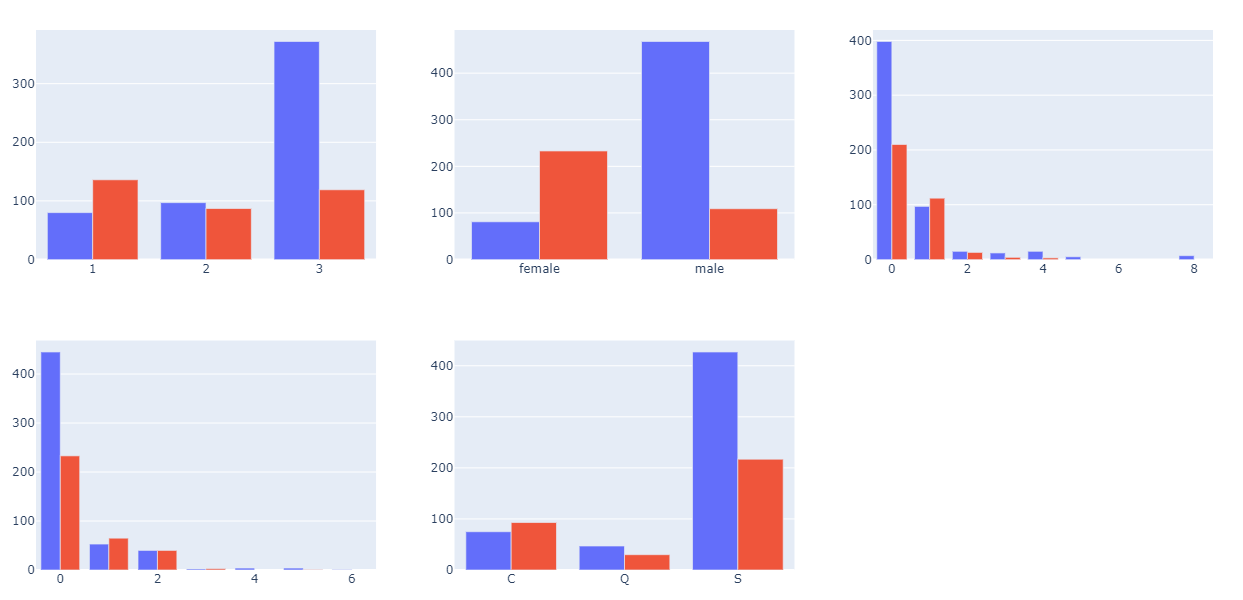

In [50]:
fig_plotly = make_subplots(rows=2, cols=3)

fig_plotly.add_traces(subfig_1['data'], rows=1, cols=1)
fig_plotly.add_traces(subfig_2['data'], rows=1, cols=2)
fig_plotly.add_traces(subfig_3['data'], rows=1, cols=3)
fig_plotly.add_traces(subfig_4['data'], rows=2, cols=1)
fig_plotly.add_traces(subfig_5['data'], rows=2, cols=2)
# fig_plotly.add_traces(subfig_6['data'], rows=2, cols=2)
# fig_plotly.add_traces(subfig_7['data'], rows=2, cols=3)

fig_plotly.update_layout(
    showlegend=False,
    width=960, height=600, autosize=False,
    margin=dict(l=30, r=30, t=30, b=30)
)

In [34]:
fig_plotly.layout

Layout({
    'autosize': False,
    'height': 600,
    'margin': {'b': 30, 'l': 30, 'r': 30, 't': 30},
    'showlegend': False,
    'template': '...',
    'width': 960,
    'xaxis': {'anchor': 'y', 'domain': [0.0, 0.2888888888888889]},
    'xaxis2': {'anchor': 'y2', 'domain': [0.35555555555555557, 0.6444444444444445]},
    'xaxis3': {'anchor': 'y3', 'domain': [0.7111111111111111, 1.0]},
    'xaxis4': {'anchor': 'y4', 'domain': [0.0, 0.2888888888888889]},
    'xaxis5': {'anchor': 'y5', 'domain': [0.35555555555555557, 0.6444444444444445]},
    'xaxis6': {'anchor': 'y6', 'domain': [0.7111111111111111, 1.0]},
    'yaxis': {'anchor': 'x', 'domain': [0.575, 1.0]},
    'yaxis2': {'anchor': 'x2', 'domain': [0.575, 1.0]},
    'yaxis3': {'anchor': 'x3', 'domain': [0.575, 1.0]},
    'yaxis4': {'anchor': 'x4', 'domain': [0.0, 0.425]},
    'yaxis5': {'anchor': 'x5', 'domain': [0.0, 0.425]},
    'yaxis6': {'anchor': 'x6', 'domain': [0.0, 0.425]}
})

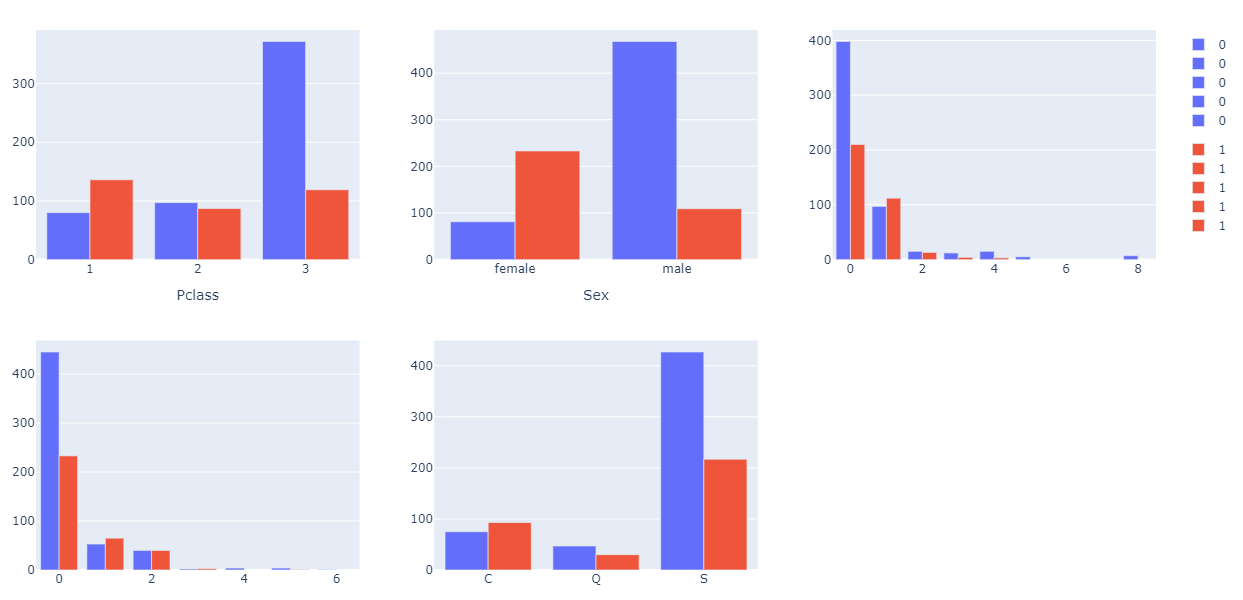

In [56]:
fig_plotly.update_layout(xaxis_title_text='Pclass', xaxis2_title_text='Sex')

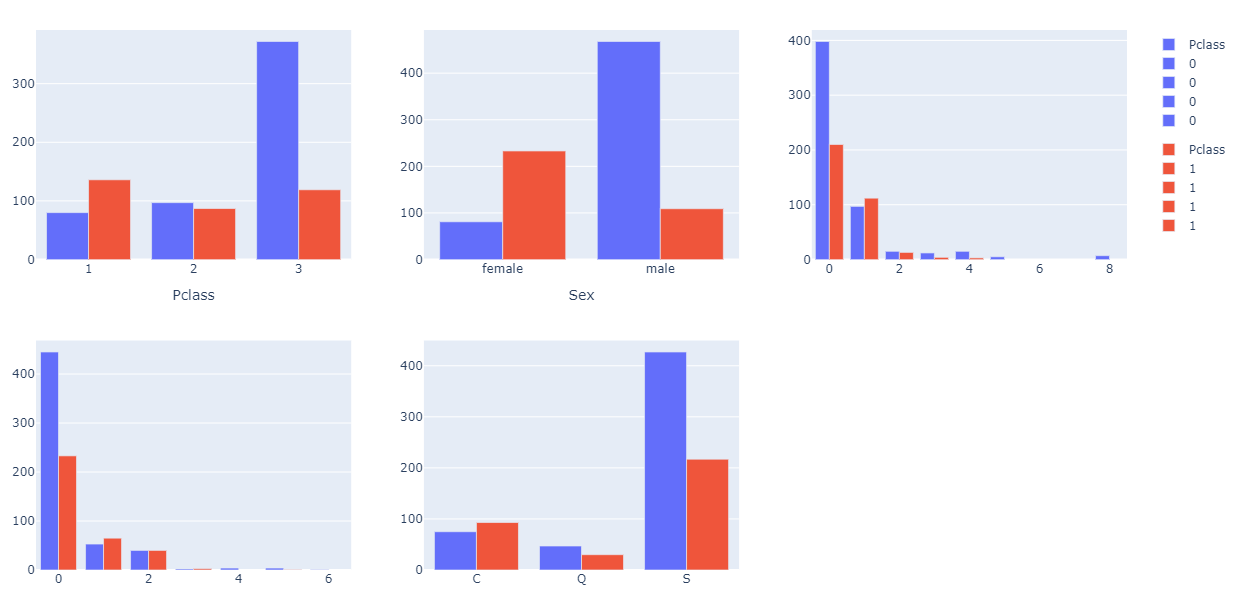

In [57]:
fig_plotly.update_traces(row=1, col=1, name='Pclass')

In [24]:
subfig_1.to_dict()

{'data': [{'alignmentgroup': 'True',
   'hovertemplate': 'Survived=0<br>Pclass=%{x}<br>size=%{y}<extra></extra>',
   'legendgroup': '0',
   'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
   'name': '0',
   'offsetgroup': '0',
   'orientation': 'v',
   'showlegend': True,
   'textposition': 'auto',
   'x': array([1, 2, 3], dtype=int64),
   'xaxis': 'x',
   'y': array([ 80,  97, 372], dtype=int64),
   'yaxis': 'y',
   'type': 'bar'},
  {'alignmentgroup': 'True',
   'hovertemplate': 'Survived=1<br>Pclass=%{x}<br>size=%{y}<extra></extra>',
   'legendgroup': '1',
   'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
   'name': '1',
   'offsetgroup': '1',
   'orientation': 'v',
   'showlegend': True,
   'textposition': 'auto',
   'x': array([1, 2, 3], dtype=int64),
   'xaxis': 'x',
   'y': array([136,  87, 119], dtype=int64),
   'yaxis': 'y',
   'type': 'bar'}],
 'layout': {'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'},
      'error_y': {'color': '#2a3f5f'}

In [31]:
subfig_1.layout.__class__

plotly.graph_objs._layout.Layout

In [32]:
subfig_1.layout

Layout({
    'barmode': 'group',
    'legend': {'title': {'text': 'Survived'}, 'tracegroupgap': 0},
    'margin': {'t': 60},
    'template': '...',
    'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Pclass'}},
    'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'size'}}
})

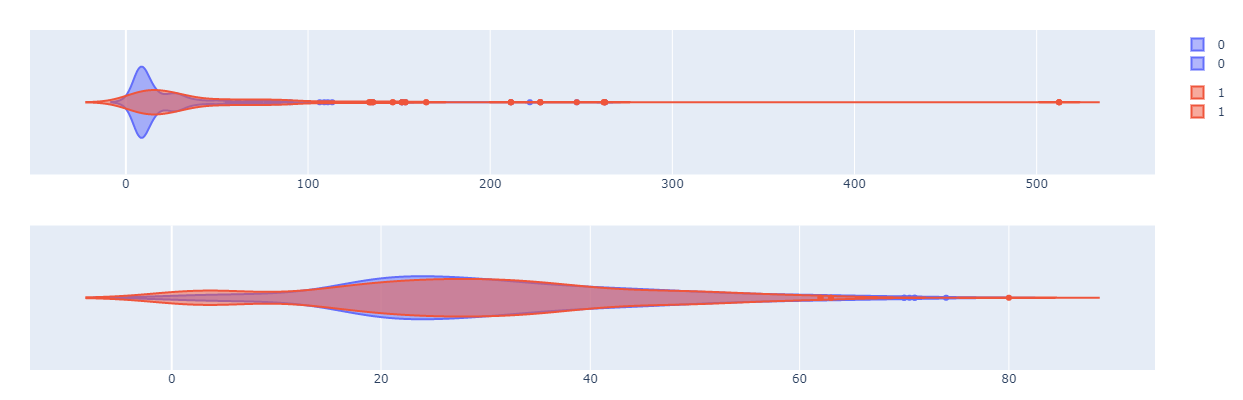

In [13]:
fig_plotly = make_subplots(rows=2, cols=1)
fig_plotly.add_traces(subfig_6['data'], rows=1, cols=1)
fig_plotly.add_traces(subfig_7['data'], rows=2, cols=1)
fig_plotly.update_layout(
    width=600, height=400, autosize=False,
    margin=dict(l=30, r=30, t=30, b=30)
)

In [94]:
t = fig_plotly.to_dict()

In [96]:
t_data = t['data']
t_layout = t['layout']

In [98]:
len(t_data)

4

In [99]:
t_data[0]

{'alignmentgroup': 'True',
 'box': {'visible': False},
 'hovertemplate': 'Survived=0<br>Fare=%{x}<extra></extra>',
 'legendgroup': '0',
 'marker': {'color': '#636efa'},
 'name': '0',
 'offsetgroup': '0',
 'orientation': 'h',
 'scalegroup': 'True',
 'showlegend': True,
 'x': array([  7.25  ,   8.05  ,   8.4583,  51.8625,  21.075 ,   8.05  ,
         31.275 ,   7.8542,  29.125 ,  18.    ,  26.    ,  21.075 ,
          7.225 , 263.    ,   7.8958,  27.7208,  10.5   ,  82.1708,
         52.    ,   8.05  ,  18.    ,   9.475 ,  21.    ,   7.8958,
          8.05  ,  15.5   ,  21.6792,  17.8   ,  39.6875,   7.8   ,
         61.9792,   7.2292,  46.9   ,   7.2292,  83.475 ,  27.9   ,
         27.7208,   8.1583,   8.6625,  10.5   ,  46.9   ,  73.5   ,
         14.4542,   7.65  ,   7.8958,   8.05  ,   9.    ,  47.1   ,
         34.375 ,   8.05  ,   8.05  ,   8.05  ,   7.8542,  61.175 ,
         20.575 ,   7.25  ,   8.05  ,  34.6542,  26.    ,   7.8958,
          7.8958,  77.2875,   8.6542,   7.925 

In [100]:
t_layout

{'template': {'data': {'bar': [{'error_x': {'color': '#2a3f5f'},
     'error_y': {'color': '#2a3f5f'},
     'marker': {'line': {'color': '#E5ECF6', 'width': 0.5},
      'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}},
     'type': 'bar'}],
   'barpolar': [{'marker': {'line': {'color': '#E5ECF6', 'width': 0.5},
      'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}},
     'type': 'barpolar'}],
   'carpet': [{'aaxis': {'endlinecolor': '#2a3f5f',
      'gridcolor': 'white',
      'linecolor': 'white',
      'minorgridcolor': 'white',
      'startlinecolor': '#2a3f5f'},
     'baxis': {'endlinecolor': '#2a3f5f',
      'gridcolor': 'white',
      'linecolor': 'white',
      'minorgridcolor': 'white',
      'startlinecolor': '#2a3f5f'},
     'type': 'carpet'}],
   'choropleth': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
     'type': 'choropleth'}],
   'contour': [{'colorbar': {'outlinewidth': 0, 'ticks': ''},
     'colorscale': [[0.0, '#0d0887'],
      [0.

In [102]:
fig_plotly.__class__

plotly.graph_objs._figure.Figure

In [103]:
subfig_1.__class__

plotly.graph_objs._figure.Figure